In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

In [2]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

# Create a combined engagement score
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]

# Normalize for plotting if needed
scaler = MinMaxScaler()
df["engagement_normalized"] = scaler.fit_transform(df[["engagement_score"]])

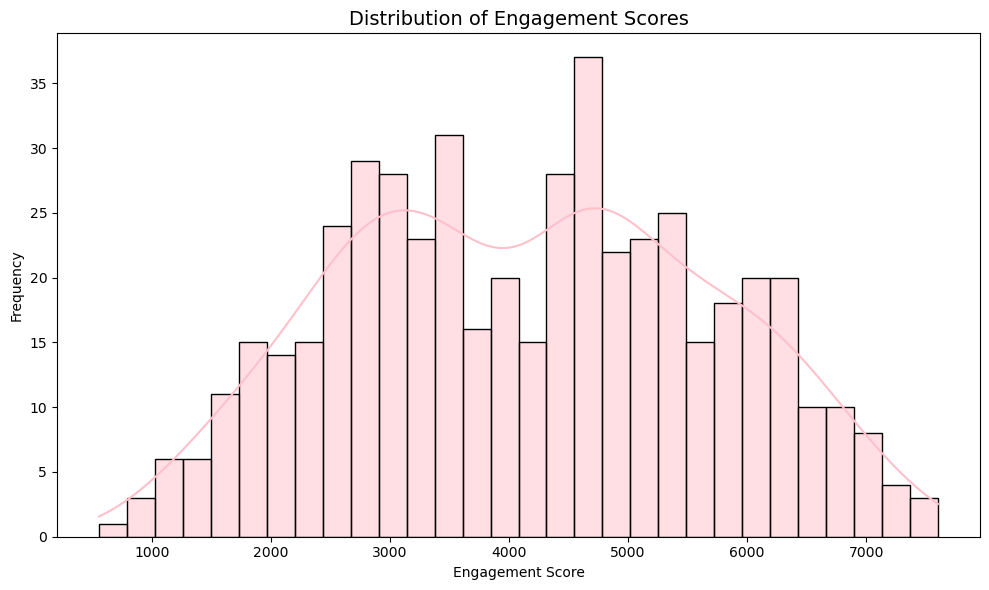

In [3]:
# Plot: Engagement Score Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df["engagement_score"], bins=30, kde=True, color="pink")
plt.title("Distribution of Engagement Scores", fontsize=14)
plt.xlabel("Engagement Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

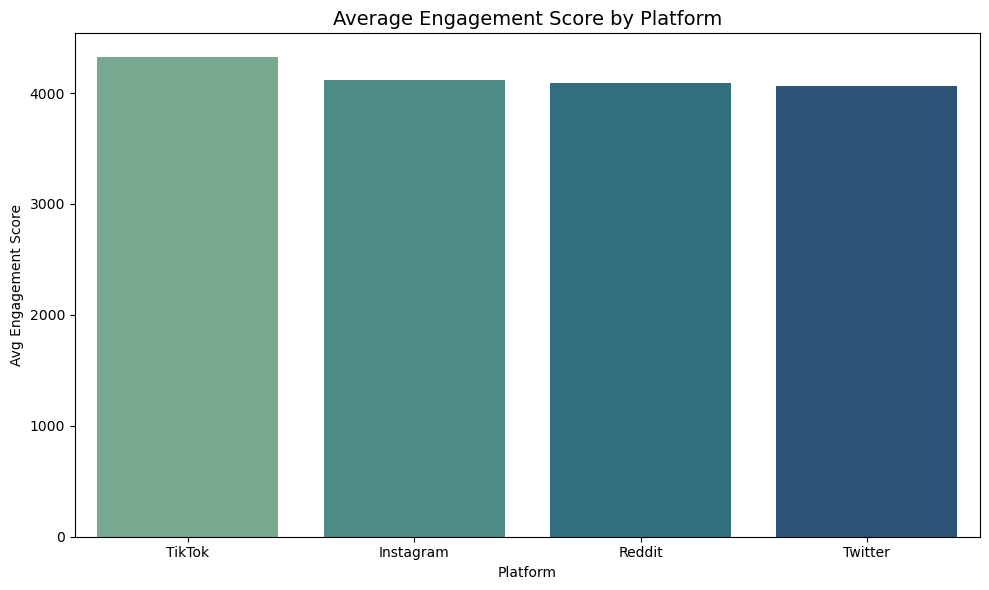

In [4]:
# Plot: Average Engagement by Platform
plt.figure(figsize=(10, 6))
platform_avg = df.groupby("platform")["engagement_score"].mean().sort_values(ascending=False)
sns.barplot(x=platform_avg.index, y=platform_avg.values, palette="crest")
plt.title("Average Engagement Score by Platform", fontsize=14)
plt.xlabel("Platform")
plt.ylabel("Avg Engagement Score")
plt.tight_layout()
plt.show()

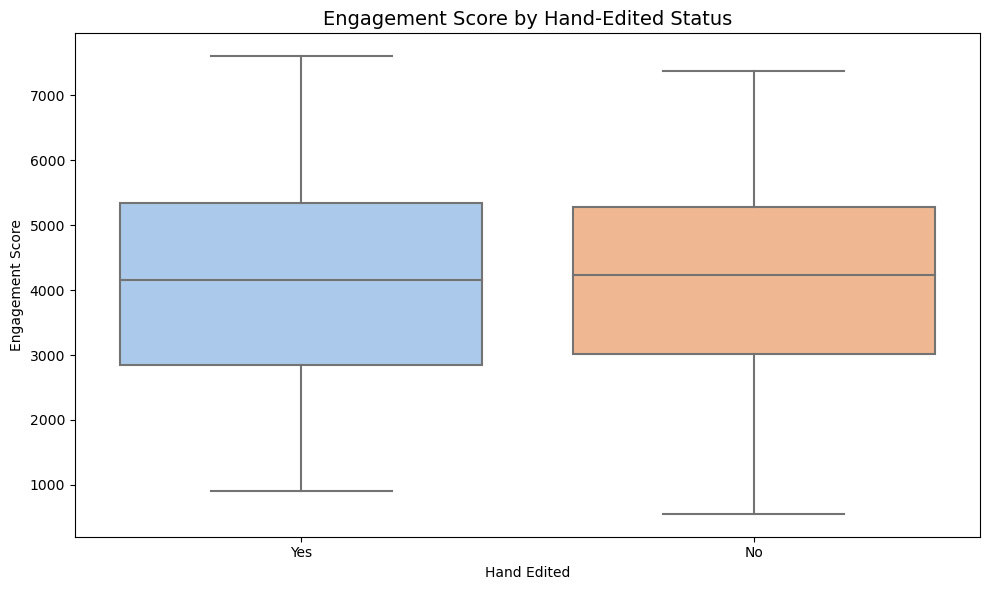

In [5]:
# Plot: Hand-Edited vs Non-Edited
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_hand_edited", y="engagement_score", data=df, palette="pastel")
plt.title("Engagement Score by Hand-Edited Status", fontsize=14)
plt.xlabel("Hand Edited")
plt.ylabel("Engagement Score")
plt.tight_layout()
plt.show()

In [4]:
!pip install wordcloud

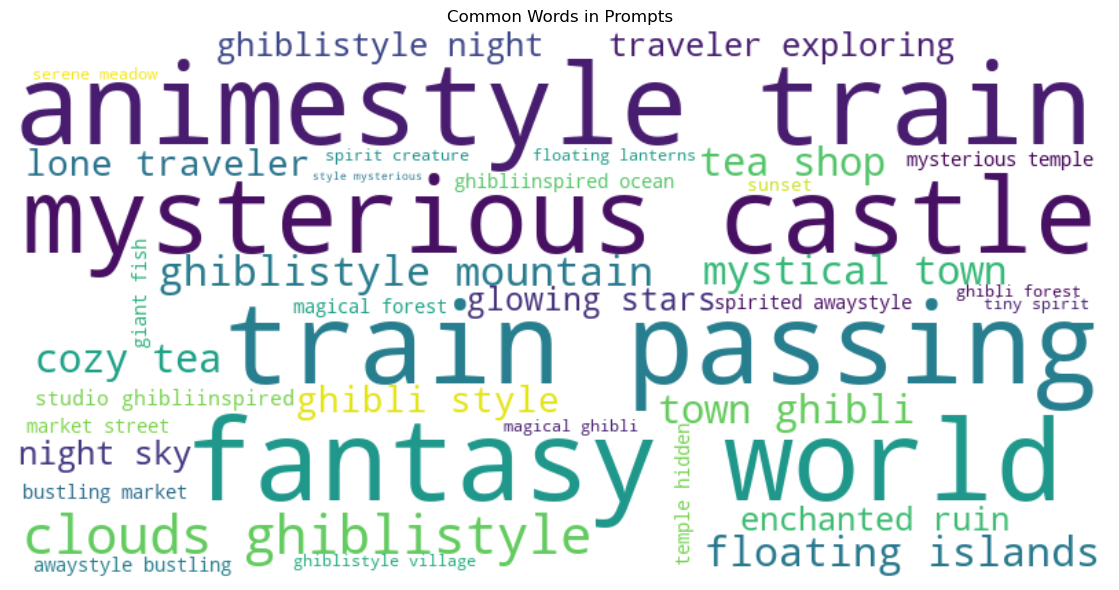

In [6]:
# Plot: Prompt Word Cloud
from wordcloud import WordCloud
import re

# Combine all prompts into one string
all_prompts = " ".join(df["prompt"].tolist()).lower()
all_prompts = re.sub(r"[^a-zA-Z\s]", "", all_prompts)  # clean punctuation

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_prompts)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Prompts")
plt.tight_layout()
plt.show()

Top 10 most frequent words:
a: 215
with: 197
ghiblistyle: 174
in: 131
mysterious: 87
floating: 82
ghibli: 78
magical: 72
forest: 72
animestyle: 57


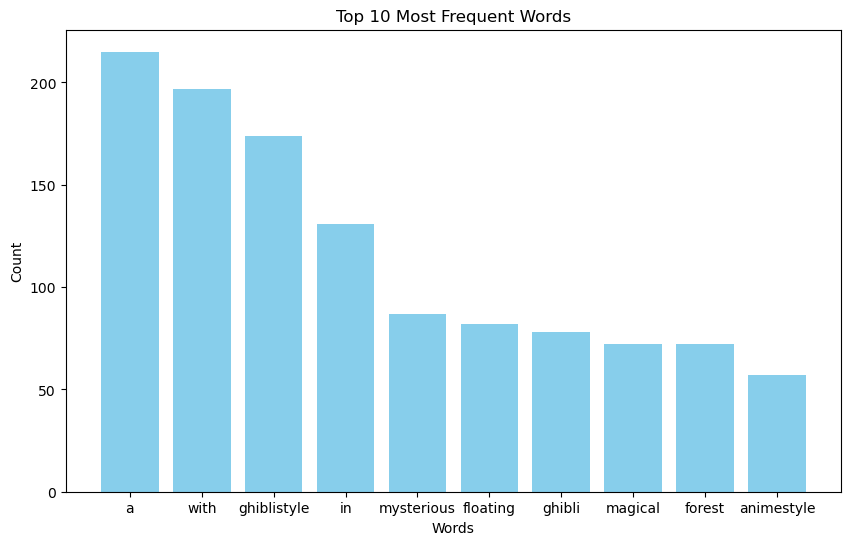

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all prompts into one string and clean punctuation (already done)
# all_prompts = " ".join(df["prompt"].tolist()).lower()
# all_prompts = re.sub(r"[^a-zA-Z\s]", "", all_prompts)  # clean punctuation

# Split text into individual words
words = all_prompts.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get the 10 most common words (adjust the number if desired)
most_common = word_counts.most_common(10)

print("Top 10 most frequent words:")
for word, count in most_common:
    print(f"{word}: {count}")

# Optionally, plot a bar chart to visualize the counts
words_list, counts_list = zip(*most_common)
plt.figure(figsize=(10,6))
plt.bar(words_list, counts_list, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Top 10 Most Frequent Words")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\psajj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.96      0.82        72
           1       0.25      0.04      0.06        28

    accuracy                           0.70       100
   macro avg       0.48      0.50      0.44       100
weighted avg       0.59      0.70      0.61       100


🧠 Top Keywords by Topic:
Topic #1: style, cozy, town, shop, tea, mystical, meadow, serene, spirit, creature
Topic #2: islands, mountain, floating, ghiblistyle, magical, forest, ghibli, sunset, village, castle
Topic #3: stars, glowing, night, sky, traveler, lone, ruin, enchanted, exploring, fish
Topic #4: mysterious, castle, clouds, temple, hidden, ghiblistyle, bustling, awaystyle, market, street
Topic #5: world, passing, fantasy, animestyle, train, village, sunset, lanterns, magical, forest


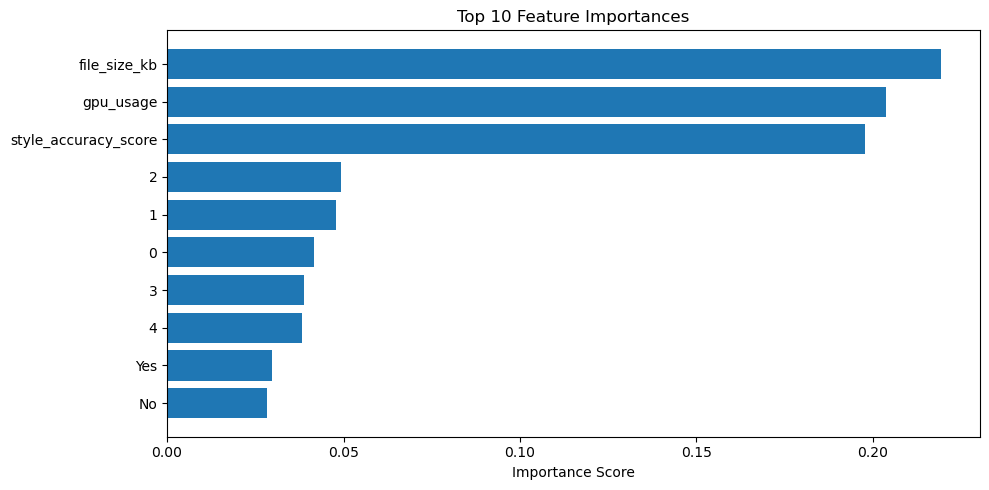

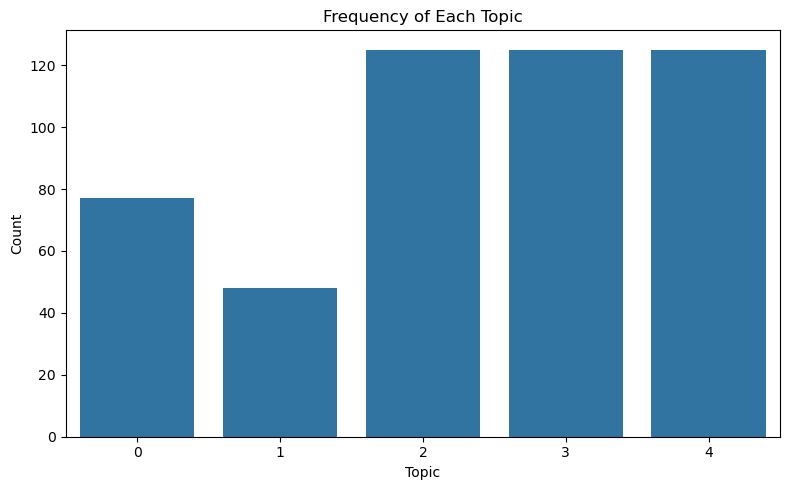

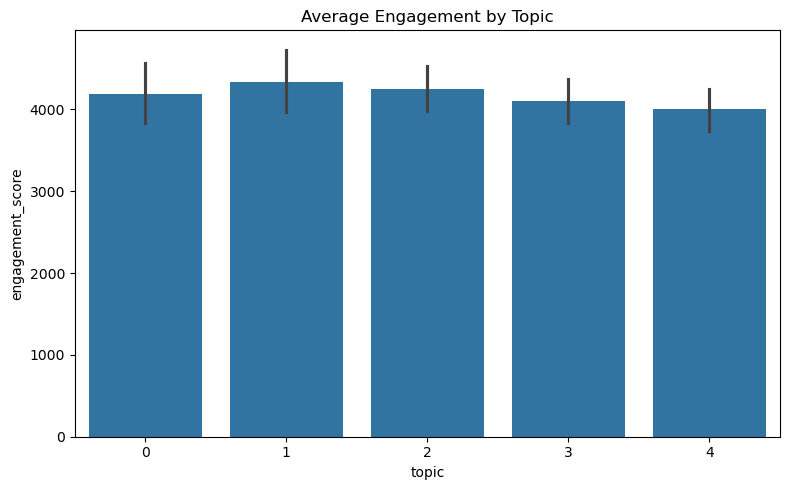

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Prompt cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])

df["clean_prompt"] = df["prompt"].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df["clean_prompt"])

# LDA topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

df["topic"] = np.argmax(lda_topics, axis=1)
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]
threshold = df["engagement_score"].quantile(0.75)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)


# Classifier features
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)
y = df["high_engagement"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Topic keywords
feature_names = vectorizer.get_feature_names_out()
print("\n🧠 Top Keywords by Topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# 🔥 Feature Importance Plot
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10
plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

# 📊 Topic Frequency Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=df["topic"])
plt.title("Frequency of Each Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("topic_frequency.png")
plt.show()

# 📈 Engagement per Topic
plt.figure(figsize=(8, 5))
sns.barplot(x="topic", y="engagement_score", data=df)
plt.title("Average Engagement by Topic")
plt.tight_layout()
plt.savefig("engagement_by_topic.png")
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\2037007595.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion_high_engagement.index, y=proportion_high_engagement.values, palette="viridis")


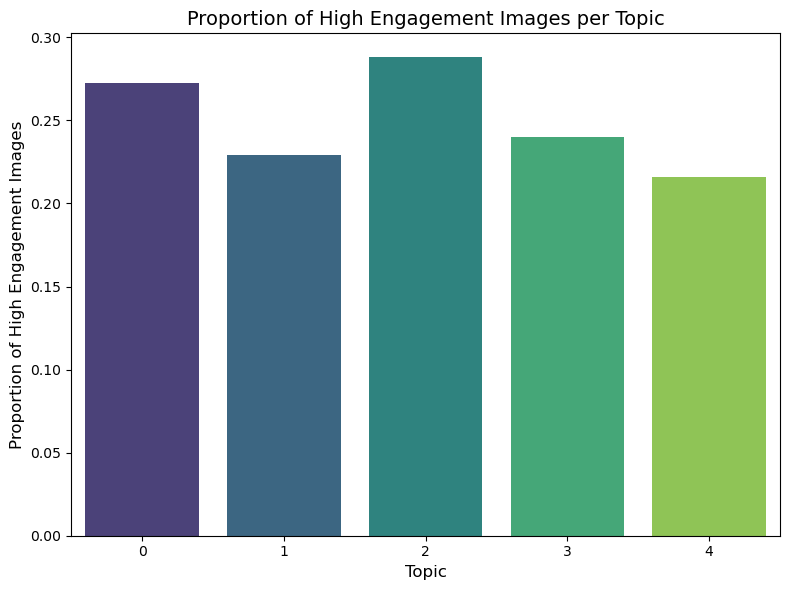

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the total number of images per topic
total_topic_counts = df["topic"].value_counts().sort_index()

# Count the number of high engagement images per topic
high_engagement_counts = df[df["high_engagement"] == 1]["topic"].value_counts().sort_index()

# Calculate the proportion of high engagement images for each topic
proportion_high_engagement = (high_engagement_counts / total_topic_counts).fillna(0)

# Plot the proportions
plt.figure(figsize=(8, 6))
sns.barplot(x=proportion_high_engagement.index, y=proportion_high_engagement.values, palette="viridis")
plt.title("Proportion of High Engagement Images per Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Proportion of High Engagement Images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\3581209562.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion_high_weighted_engagement.index, y=proportion_high_weighted_engagement.values, palette="viridis")


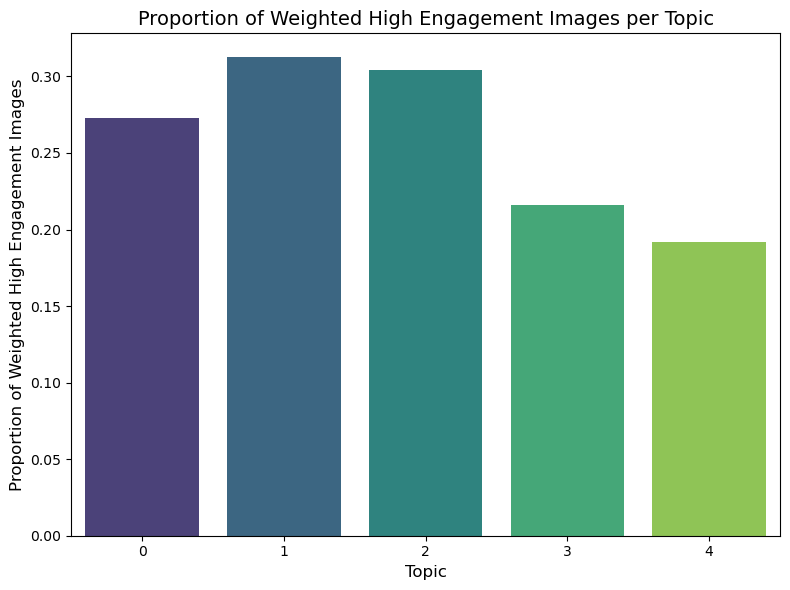

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the total number of images per topic
total_topic_counts = df["topic"].value_counts().sort_index()

# Count the number of high weighted engagement images per topic
high_weighted_engagement_counts = df[df["high_weighted_engagement"] == 1]["topic"].value_counts().sort_index()

# Calculate the proportion of high weighted engagement images for each topic
proportion_high_weighted_engagement = (high_weighted_engagement_counts / total_topic_counts).fillna(0)

# Plot the proportions
plt.figure(figsize=(8, 6))
sns.barplot(x=proportion_high_weighted_engagement.index, y=proportion_high_weighted_engagement.values, palette="viridis")
plt.title("Proportion of Weighted High Engagement Images per Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Proportion of Weighted High Engagement Images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [9]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("AI-Generated Ghibli Trend Analysis")

st.markdown("### Engagement vs Topic")
img = plt.imread("engagement_by_topic.png")
st.image(img)

st.markdown("### Topic Frequency")
img2 = plt.imread("topic_frequency.png")
st.image(img2)

st.markdown("### Feature Importance")
img3 = plt.imread("feature_importance.png")
st.image(img3)

2025-04-15 21:46:44.799 
  command:

    streamlit run c:\Users\psajj\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [10]:
#streamlit run app.py

In [11]:
# Purpose: Discover the themes people are prompting most often in Ghibli-style image generation — 
# this tells you what kinds of story concepts users are imagining.
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

# Clean prompts
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])
df["clean_prompt"] = df["prompt"].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df["clean_prompt"])

# LDA Clustering (Topic Modeling)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
df["topic"] = np.argmax(lda_topics, axis=1)

# Engagement score
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]

# Classifier target (top 25% is high engagement)
threshold = df["engagement_score"].quantile(0.75)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# Prepare features
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)
y = df["high_engagement"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Show top keywords per topic
feature_names = vectorizer.get_feature_names_out()
print("\nTop Keywords by Topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# -------------------------------
# NEW: Display Most Predictive Features from the Random Forest
# -------------------------------
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop Predictive Features (Random Forest):")
for i in range(min(10, len(indices))):  # display top 10 features
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\psajj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.96      0.82        72
           1       0.25      0.04      0.06        28

    accuracy                           0.70       100
   macro avg       0.48      0.50      0.44       100
weighted avg       0.59      0.70      0.61       100


Top Keywords by Topic:
Topic #1: style, cozy, town, shop, tea, mystical, meadow, serene, spirit, creature
Topic #2: islands, mountain, floating, ghiblistyle, magical, forest, ghibli, sunset, village, castle
Topic #3: stars, glowing, night, sky, traveler, lone, ruin, enchanted, exploring, fish
Topic #4: mysterious, castle, clouds, temple, hidden, ghiblistyle, bustling, awaystyle, market, street
Topic #5: world, passing, fantasy, animestyle, train, village, sunset, lanterns, magical, forest

Top Predictive Features (Random Forest):
file_size_kb: 0.2194
gpu_usage: 0.2038
style_accuracy_score: 0.1976
2: 0.0493
1: 0.0478
0: 0.0417
3: 0.0389
4: 0

Training Accuracy: 0.7514285714285714
Test Accuracy: 0.74


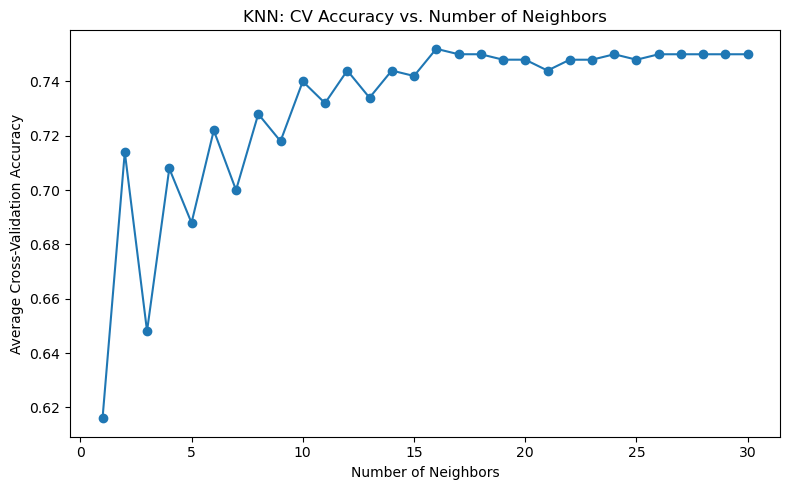

Baseline Accuracy (majority class): 0.7533333333333333
KNN Test Accuracy: 0.74
The KNN model does not perform better than the baseline prediction.

Permutation Importances for KNN:
Yes: 0.0153
No: 0.0153
file_size_kb: 0.0033
gpu_usage: 0.0027
4: 0.0027
1: 0.0007
Twitter: 0.0000
Instagram: 0.0000
style_accuracy_score: -0.0007
3: -0.0007


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Scale features for KNN (KNN is sensitive to feature scales)
scaler_knn = StandardScaler()
X_scaled_knn = scaler_knn.fit_transform(X)

# Create training and test sets using stratification to preserve class balance
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_scaled_knn, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and fit the KNN classifier with 15 neighbors
knn_model = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=2)
knn_model.fit(X_train_knn, y_train_knn)

# Evaluate on the training set
train_acc = accuracy_score(y_train_knn, knn_model.predict(X_train_knn))
print("Training Accuracy:", train_acc)

# Evaluate on the test set
test_acc = accuracy_score(y_test_knn, knn_model.predict(X_test_knn))
print("Test Accuracy:", test_acc)

# --- Cross-Validation: Accuracy vs. Number of Neighbors ---
def cv_accuracy_score(X, y, k):
    """
    Trains a KNN model with k neighbors using 3-fold stratified cross-validation
    and returns the average accuracy.
    """
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    accuracies = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, holdout_idx in skf.split(X, y):
        X_train_cv, X_holdout_cv = X[train_idx], X[holdout_idx]
        # Note: y is a pandas Series so we use .iloc for indexing
        y_train_cv, y_holdout_cv = y.iloc[train_idx], y.iloc[holdout_idx]
        knn.fit(X_train_cv, y_train_cv)
        acc = accuracy_score(y_holdout_cv, knn.predict(X_holdout_cv))
        accuracies.append(acc)
    return np.mean(accuracies)

# Explore how accuracy changes over a range of k values
neighbors_range = range(1, 31)
cv_scores = [cv_accuracy_score(X_scaled_knn, y, k) for k in neighbors_range]

plt.figure(figsize=(8, 5))
plt.plot(neighbors_range, cv_scores, marker='o')
plt.xlabel("Number of Neighbors")
plt.ylabel("Average Cross-Validation Accuracy")
plt.title("KNN: CV Accuracy vs. Number of Neighbors")
plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score

# Determine the majority class from the training data
majority_class = y_train_knn.mode()[0]

# Create baseline predictions for the test set by assigning the majority class to all instances
baseline_predictions = np.full(shape=y_test_knn.shape, fill_value=majority_class)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(y_test_knn, baseline_predictions)
print("Baseline Accuracy (majority class):", baseline_accuracy)

# Compare with the KNN model test accuracy (test_acc computed earlier)
print("KNN Test Accuracy:", test_acc)

if test_acc > baseline_accuracy:
    print("The KNN model performs better than the baseline prediction.")
else:
    print("The KNN model does not perform better than the baseline prediction.")

# -------------------------------
# NEW: Permutation Importance for KNN Model
# -------------------------------
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set for the KNN model
perm_importance = permutation_importance(knn_model, X_test_knn, y_test_knn, n_repeats=10, random_state=42, scoring='accuracy')
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

print("\nPermutation Importances for KNN:")
for idx in sorted_idx[:10]:  # display top 10 features
    print(f"{X.columns[idx]}: {perm_importance.importances_mean[idx]:.4f}")


In [30]:
from sklearn.metrics import accuracy_score

# Determine the majority class from the training data
majority_class = y_train_knn.mode()[0]

# Create baseline predictions for the test set by assigning the majority class to all instances
baseline_predictions = np.full(shape=y_test_knn.shape, fill_value=majority_class)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(y_test_knn, baseline_predictions)
print("Baseline Accuracy (majority class):", baseline_accuracy)

# Compare with the KNN model test accuracy (test_acc computed earlier)
print("KNN Test Accuracy:", test_acc)

# Check if the KNN model is performing better than the baseline
if test_acc > baseline_accuracy:
    print("The KNN model performs better than the baseline prediction.")
else:
    print("The KNN model does not perform better than the baseline prediction.")


Baseline Accuracy (majority class): 0.7533333333333333
KNN Test Accuracy: 0.74
The KNN model does not perform better than the baseline prediction.


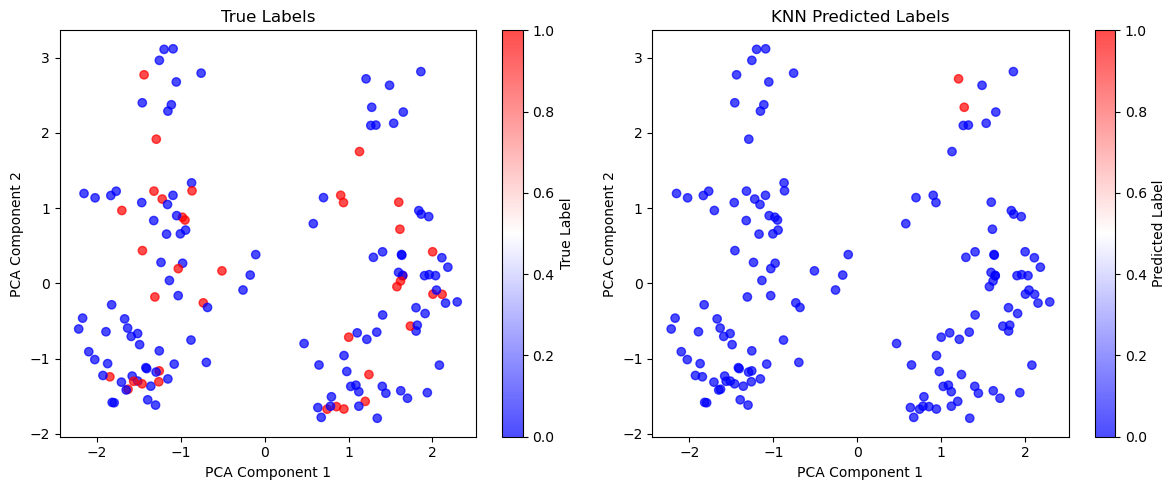

In [13]:
from sklearn.decomposition import PCA

# Obtain predictions for the test set
knn_predictions = knn_model.predict(X_test_knn)

# Reduce the test set dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_knn)

# Create side-by-side scatter plots for comparison
plt.figure(figsize=(12, 5))

# Plot 1: True Labels
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_knn, cmap='bwr', alpha=0.7)
plt.title("True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_true, label='True Label')

# Plot 2: KNN Predicted Labels
plt.subplot(1, 2, 2)
scatter_pred = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=knn_predictions, cmap='bwr', alpha=0.7)
plt.title("KNN Predicted Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_pred, label='Predicted Label')

plt.tight_layout()
plt.show()


In [18]:
Model 1: Latent Dirichlet Allocation (LDA) — Clustering Prompts into Topics
- What It Does:
Groups all user prompts into themes or topics based on the words they use.
Helps identify what kind of stories people are imagining when they generate Ghibli-style art.

- What the Code Does:
1) Cleans the prompt text (removes stopwords and punctuation).
2) Converts prompts into a numeric format using TF-IDF.
3) Applies LDA to find 5 common clusters (or topics).
4) Assigns each prompt to one topic.

- What the Output Means (from your result):
Example output:
Topic #1 might represent prompts about small cozy villages or shops (slice-of-life Ghibli vibes).
Topic #2 is about magical floating landscapes and scenic beauty.

- Why It’s Useful:
This shows what kinds of Ghibli-style content people want to see — a form of crowdsourced demand for new movie themes.

SyntaxError: invalid character '—' (U+2014) (377034152.py, line 1)

In [ ]:
Model 2: Random Forest Classifier — Predicting Engagement
- What It Does:
Predicts whether a prompt will lead to high engagement (likes, shares, comments).
Helps figure out what features make an image go viral.

- What the Code Does:
1) Adds a column for “high engagement” (top 25% of posts).
2) Uses features like:
Thematic topic (from LDA),Style accuracy,Platform (Instagram/TikTok/etc.),Whether it was hand-edited.
3) Trains a Random Forest model to predict whether a new prompt will be popular.
4) Outputs model performance (classification report).

- What the Output Means (from your result):
The model isn’t perfect — it struggles to predict viral prompts.
But it shows which features matter most (like prompt topic, platform, editing).

- Why It’s Useful:
Studios can use this to forecast demand — which themes or types of AI content are likely to succeed, so they invest in the right ideas.

In [ ]:
Model 3: K-Nearest Neighbors Classifier - Predicting Virality
- What It Does:
    

SyntaxError: invalid syntax (1016034783.py, line 1)

Weighted Engagement Score Section

In [45]:
# Assign weights to likes, shares, and comments
like_weight = 1
share_weight = 3
comment_weight = 5

# Create the weighted engagement score
df["weighted_engagement_score"] = (
    (df["likes"] * like_weight) +
    (df["shares"] * share_weight) +
    (df["comments"] * comment_weight)
)
# Calculate the threshold for high weighted engagement (top 25%)
weighted_threshold = df["weighted_engagement_score"].quantile(0.75)

# Create the high_weighted_engagement column
df["high_weighted_engagement"] = (df["weighted_engagement_score"] >= weighted_threshold).astype(int)

# Normalize for plotting if needed
scaler = MinMaxScaler()
df["weighted_engagement_normalized"] = scaler.fit_transform(df[["weighted_engagement_score"]])

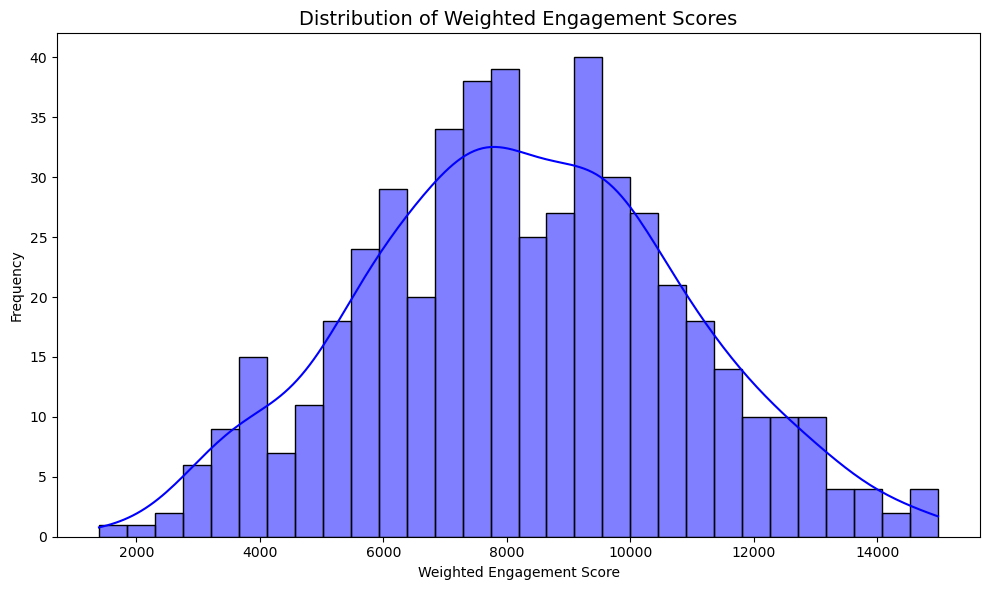

In [36]:
# Plot: Weighted Engagement Score Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df["weighted_engagement_score"], bins=30, kde=True, color="blue")
plt.title("Distribution of Weighted Engagement Scores", fontsize=14)
plt.xlabel("Weighted Engagement Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\2258756728.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_avg.index, y=platform_avg.values, palette="crest")


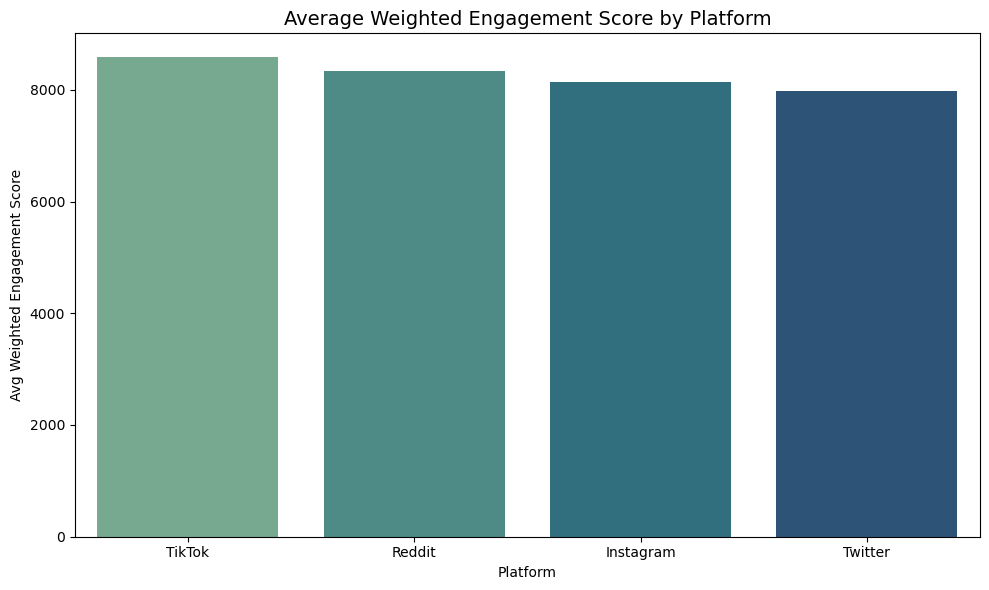

In [37]:
# Plot: Average Weighted Engagement by Platform
plt.figure(figsize=(10, 6))
platform_avg = df.groupby("platform")["weighted_engagement_score"].mean().sort_values(ascending=False)
sns.barplot(x=platform_avg.index, y=platform_avg.values, palette="crest")
plt.title("Average Weighted Engagement Score by Platform", fontsize=14)
plt.xlabel("Platform")
plt.ylabel("Avg Weighted Engagement Score")
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\1149555752.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_hand_edited", y="weighted_engagement_score", data=df, palette="pastel")


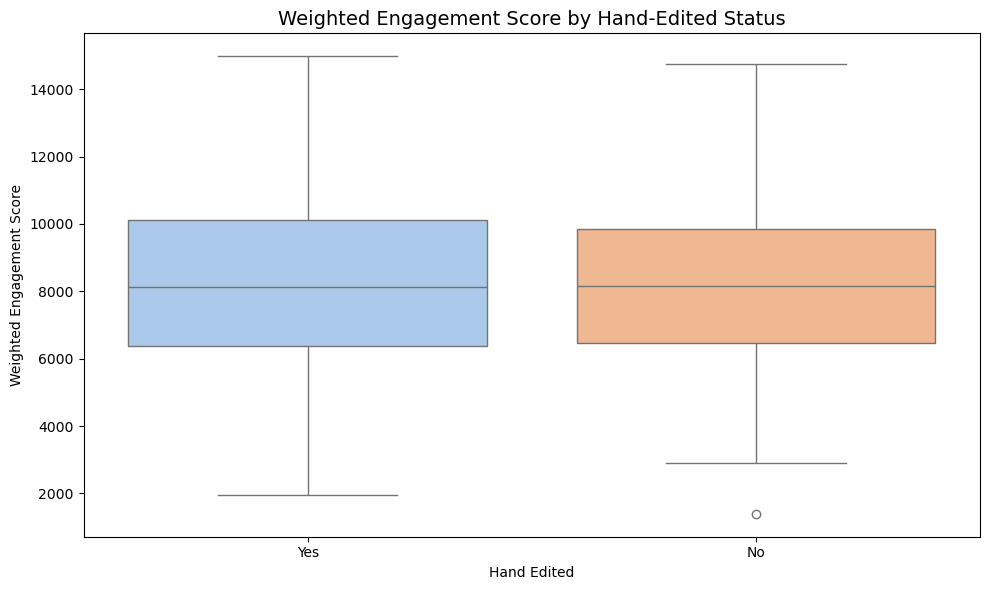

In [38]:
# Plot: Hand-Edited vs Non-Edited (Weighted Engagement)
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_hand_edited", y="weighted_engagement_score", data=df, palette="pastel")
plt.title("Weighted Engagement Score by Hand-Edited Status", fontsize=14)
plt.xlabel("Hand Edited")
plt.ylabel("Weighted Engagement Score")
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\2846328522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion_high_weighted_engagement.index, y=proportion_high_weighted_engagement.values, palette="viridis")


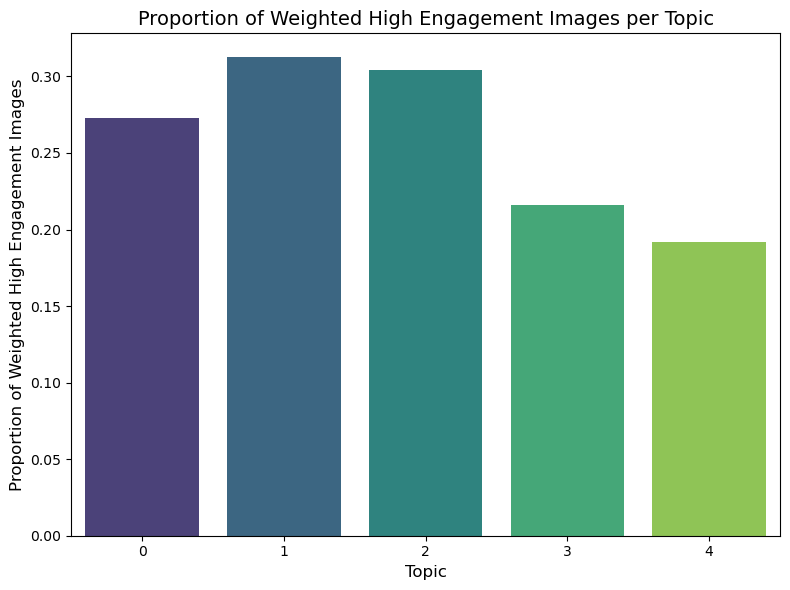

In [46]:
# Proportion of Weighted High Engagement Images per Topic
total_topic_counts = df["topic"].value_counts().sort_index()
high_weighted_engagement_counts = df[df["high_weighted_engagement"] == 1]["topic"].value_counts().sort_index()
proportion_high_weighted_engagement = (high_weighted_engagement_counts / total_topic_counts).fillna(0)

plt.figure(figsize=(8, 6))
sns.barplot(x=proportion_high_weighted_engagement.index, y=proportion_high_weighted_engagement.values, palette="viridis")
plt.title("Proportion of Weighted High Engagement Images per Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Proportion of Weighted High Engagement Images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\1179673074.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="topic", y="weighted_engagement_score", data=df, palette="coolwarm")


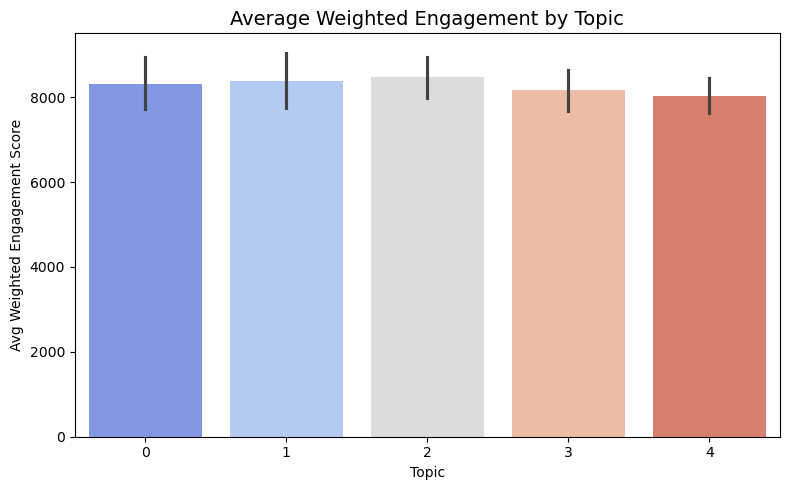

In [40]:
# Average Weighted Engagement per Topic
plt.figure(figsize=(8, 5))
sns.barplot(x="topic", y="weighted_engagement_score", data=df, palette="coolwarm")
plt.title("Average Weighted Engagement by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Avg Weighted Engagement Score")
plt.tight_layout()
plt.show()

C:\Users\psajj\AppData\Local\Temp\ipykernel_31108\42044509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion_high_weighted_engagement_platform.index, y=proportion_high_weighted_engagement_platform.values, palette="magma")


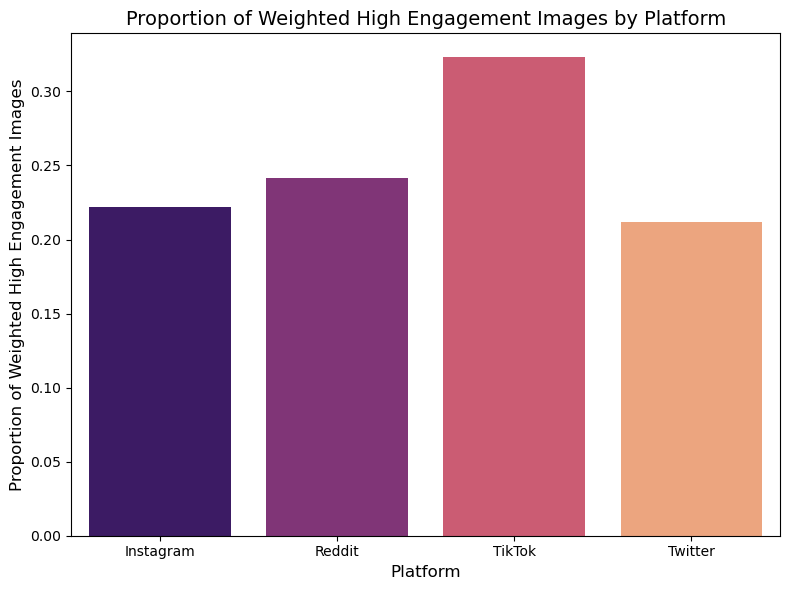

In [41]:
# Proportion of Weighted High Engagement by Platform
total_platform_counts = df["platform"].value_counts().sort_index()
high_weighted_engagement_platform_counts = df[df["high_weighted_engagement"] == 1]["platform"].value_counts().sort_index()
proportion_high_weighted_engagement_platform = (high_weighted_engagement_platform_counts / total_platform_counts).fillna(0)

plt.figure(figsize=(8, 6))
sns.barplot(x=proportion_high_weighted_engagement_platform.index, y=proportion_high_weighted_engagement_platform.values, palette="magma")
plt.title("Proportion of Weighted High Engagement Images by Platform", fontsize=14)
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Proportion of Weighted High Engagement Images", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [42]:
# Save the updated DataFrame with weighted metrics
df.to_csv("ai_ghibli_trend_dataset_v2_with_weighted_metrics.csv", index=False)


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.97      0.83        72
           1       0.50      0.07      0.12        28

    accuracy                           0.72       100
   macro avg       0.61      0.52      0.48       100
weighted avg       0.67      0.72      0.64       100


🧠 Top Keywords by Topic:
Topic #1: style, cozy, town, shop, tea, mystical, meadow, serene, spirit, creature
Topic #2: islands, mountain, floating, ghiblistyle, magical, forest, ghibli, sunset, village, castle
Topic #3: stars, glowing, night, sky, traveler, lone, ruin, enchanted, exploring, fish
Topic #4: mysterious, castle, clouds, temple, hidden, ghiblistyle, bustling, awaystyle, market, street
Topic #5: world, passing, fantasy, animestyle, train, village, sunset, lanterns, magical, forest


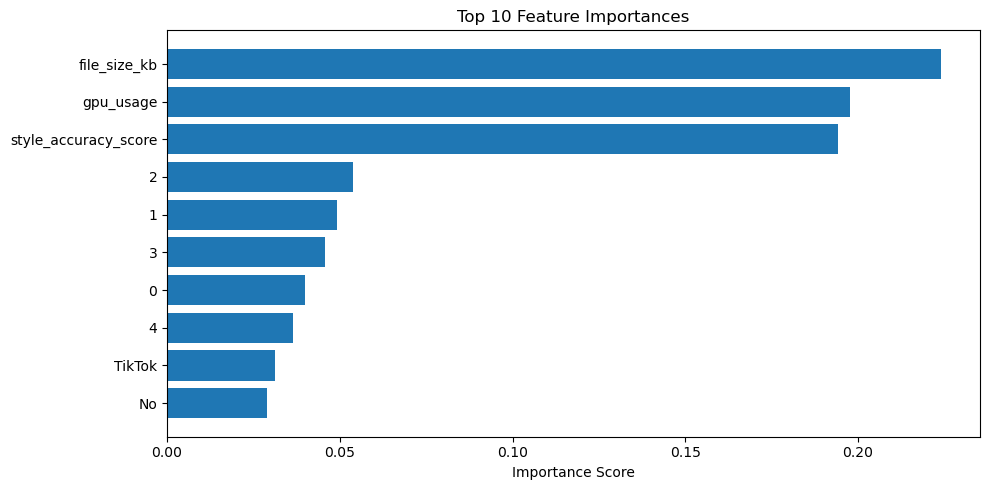

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Classifier features
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)
y = df["high_weighted_engagement"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Topic keywords
feature_names = vectorizer.get_feature_names_out()
print("\n🧠 Top Keywords by Topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# 🔥 Feature Importance Plot
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10
plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

Training Accuracy: 0.76
Test Accuracy: 0.7466666666666667


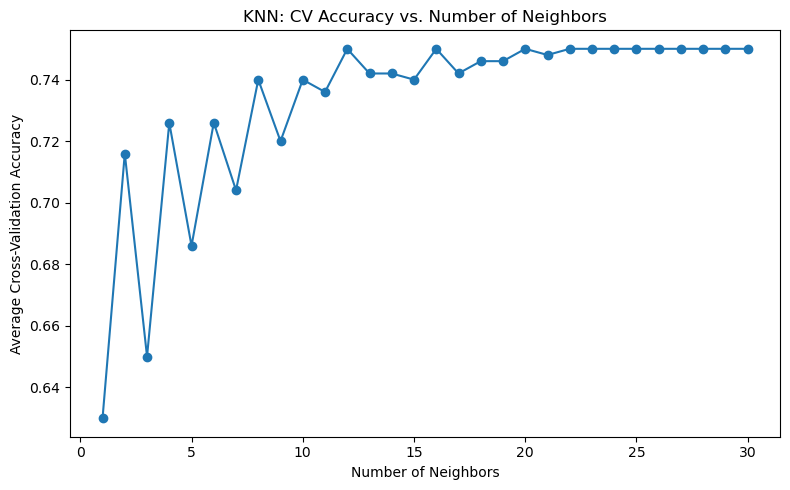

Baseline Accuracy (majority class): 0.7533333333333333
KNN Test Accuracy: 0.7466666666666667
The KNN model does not perform better than the baseline prediction.


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine features (same as the original Random Forest model)
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)  # Ensure column names are strings
y = df["high_weighted_engagement"]  # Target variable

# Scale features for KNN (KNN is sensitive to feature scales)
scaler_knn = StandardScaler()
X_scaled_knn = scaler_knn.fit_transform(X)

# Create training and test sets using stratification to preserve class balance
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_scaled_knn, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and fit the KNN classifier with 15 neighbors
knn_model = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=2)
knn_model.fit(X_train_knn, y_train_knn)

# Evaluate on the training set
train_acc = accuracy_score(y_train_knn, knn_model.predict(X_train_knn))
print("Training Accuracy:", train_acc)

# Evaluate on the test set
test_acc = accuracy_score(y_test_knn, knn_model.predict(X_test_knn))
print("Test Accuracy:", test_acc)

# --- Cross-Validation: Accuracy vs. Number of Neighbors ---
def cv_accuracy_score(X, y, k):
    """
    Trains a KNN model with k neighbors using 3-fold stratified cross-validation
    and returns the average accuracy.
    """
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    accuracies = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, holdout_idx in skf.split(X, y):
        X_train_cv, X_holdout_cv = X[train_idx], X[holdout_idx]
        y_train_cv, y_holdout_cv = y.iloc[train_idx], y.iloc[holdout_idx]
        knn.fit(X_train_cv, y_train_cv)
        acc = accuracy_score(y_holdout_cv, knn.predict(X_holdout_cv))
        accuracies.append(acc)
    return np.mean(accuracies)

# Explore how accuracy changes over a range of k values
neighbors_range = range(1, 31)
cv_scores = [cv_accuracy_score(X_scaled_knn, y, k) for k in neighbors_range]

plt.figure(figsize=(8, 5))
plt.plot(neighbors_range, cv_scores, marker='o')
plt.xlabel("Number of Neighbors")
plt.ylabel("Average Cross-Validation Accuracy")
plt.title("KNN: CV Accuracy vs. Number of Neighbors")
plt.tight_layout()
plt.show()

# Baseline comparison
# Determine the majority class from the training data
majority_class = y_train_knn.mode()[0]

# Create baseline predictions for the test set by assigning the majority class to all instances
baseline_predictions = np.full(shape=y_test_knn.shape, fill_value=majority_class)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(y_test_knn, baseline_predictions)
print("Baseline Accuracy (majority class):", baseline_accuracy)

# Compare with the KNN model test accuracy
print("KNN Test Accuracy:", test_acc)

if test_acc > baseline_accuracy:
    print("The KNN model performs better than the baseline prediction.")
else:
    print("The KNN model does not perform better than the baseline prediction.")

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': range(1, 31),  # Test k values from 1 to 30
    'p': [1, 2]  # Distance metrics: 1 for Manhattan, 2 for Euclidean
}

# Initialize GridSearchCV with KNN and the parameter grid
grid_search = GridSearchCV(
    KNeighborsClassifier(weights='uniform'),
    param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit GridSearchCV on the scaled training data
grid_search.fit(X_scaled_knn, y)

# Print the best parameters and the corresponding accuracy
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Train the KNN model with the best parameters
best_knn_model = grid_search.best_estimator_
best_knn_model.fit(X_train_knn, y_train_knn)

# Evaluate the tuned model on the test set
test_acc = accuracy_score(y_test_knn, best_knn_model.predict(X_test_knn))
print("Test Accuracy with Best Parameters:", test_acc)

Best parameters: {'n_neighbors': 6, 'p': 1}
Best cross-validation accuracy: 0.7519899959117908
Test Accuracy with Best Parameters: 0.76


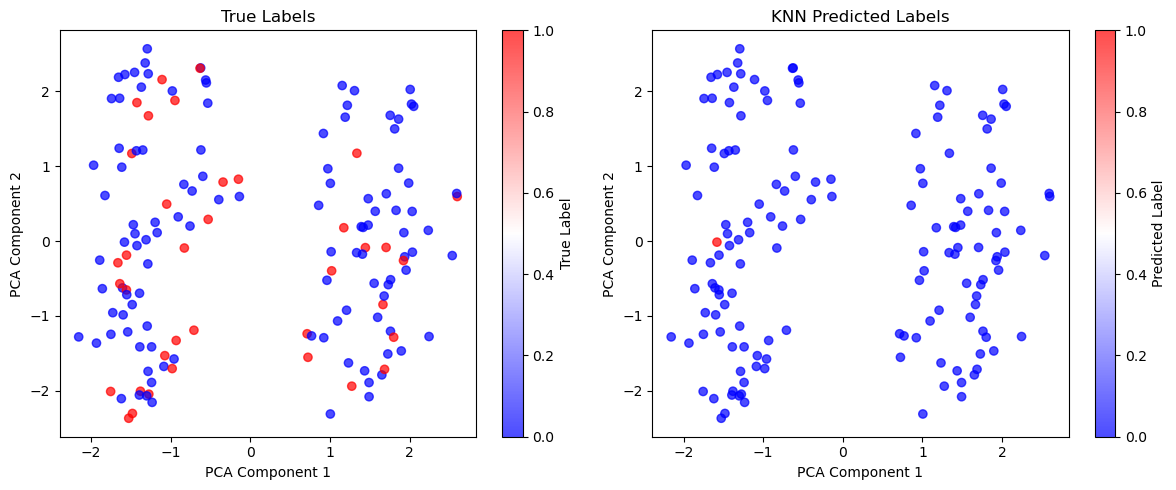

In [56]:
from sklearn.decomposition import PCA

# Obtain predictions for the test set
knn_predictions = knn_model.predict(X_test_knn)

# Reduce the test set dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_knn)

# Create side-by-side scatter plots for comparison
plt.figure(figsize=(12, 5))

# Plot 1: True Labels
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_knn, cmap='bwr', alpha=0.7)
plt.title("True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_true, label='True Label')

# Plot 2: KNN Predicted Labels
plt.subplot(1, 2, 2)
scatter_pred = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=knn_predictions, cmap='bwr', alpha=0.7)
plt.title("KNN Predicted Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_pred, label='Predicted Label')

plt.tight_layout()
plt.show()


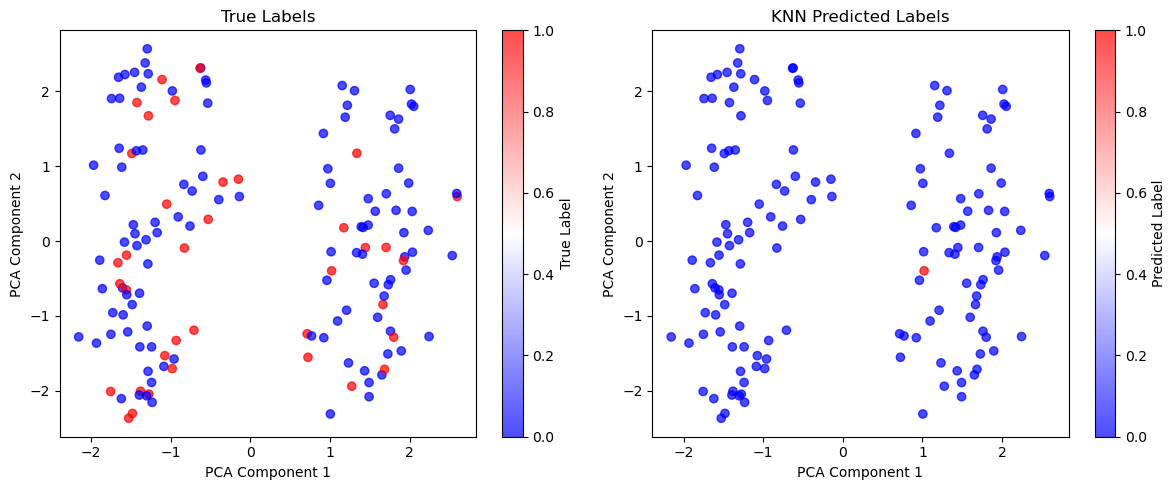

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Obtain predictions for the test set using the best KNN model
knn_predictions = best_knn_model.predict(X_test_knn)

# Reduce the test set dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_knn)

# Create side-by-side scatter plots for comparison
plt.figure(figsize=(12, 5))

# Plot 1: True Labels
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_knn, cmap='bwr', alpha=0.7)
plt.title("True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_true, label='True Label')

# Plot 2: KNN Predicted Labels
plt.subplot(1, 2, 2)
scatter_pred = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=knn_predictions, cmap='bwr', alpha=0.7)
plt.title("KNN Predicted Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_pred, label='Predicted Label')

plt.tight_layout()
plt.show()

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Combine features (same as the original Random Forest model)
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)  # Ensure column names are strings
y = df["high_weighted_engagement"]  # Target variable

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=2000, random_state=42)  # Increased max_iter for convergence
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("\n📊 Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))  # Handle undefined metrics

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


📊 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       113
           1       0.00      0.00      0.00        37

    accuracy                           0.75       150
   macro avg       0.38      0.50      0.43       150
weighted avg       0.57      0.75      0.65       150

Test Accuracy: 0.7533


In [71]:
import numpy as np
import pandas as pd

# Get the feature names
feature_names = X.columns

# Get the coefficients from the trained Logistic Regression model
coefficients = log_reg.coef_[0]

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sort by absolute coefficient value in descending order
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Display the top 10 most important features
print("\nTop 10 Most Important Features for Logistic Regression:\n")
print(feature_importance.head(10))


Top 10 Most Important Features for Logistic Regression:

                 Feature  Coefficient  Absolute Coefficient
1                      1     0.187976              0.187976
2                      2     0.140806              0.140806
5   style_accuracy_score    -0.114546              0.114546
4                      4    -0.110809              0.110809
0                      0    -0.108284              0.108284
7           file_size_kb     0.092128              0.092128
6              gpu_usage    -0.080486              0.080486
10                TikTok     0.080156              0.080156
3                      3    -0.064359              0.064359
8              Instagram    -0.043550              0.043550


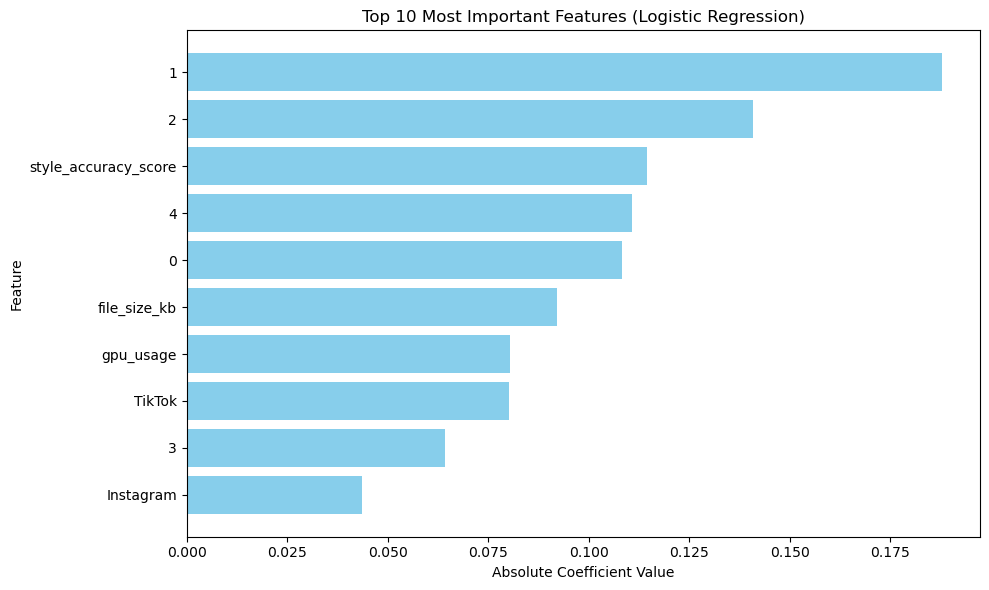

In [72]:
import matplotlib.pyplot as plt

# Plot the top 10 most important features
top_features = feature_importance.head(10)  # Select the top 10 features

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (Logistic Regression)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()
plt.show()

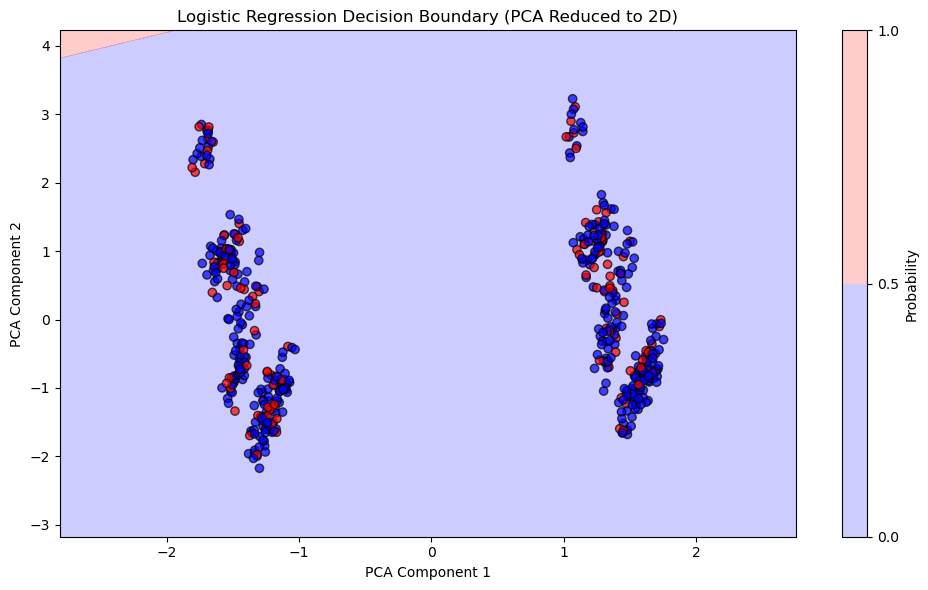

In [73]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Reduce the features to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Fit Logistic Regression on the reduced dataset
log_reg_2d = LogisticRegression(max_iter=2000, random_state=42)
log_reg_2d.fit(X_2d, y)

# Create a mesh grid for plotting the decision boundary
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict probabilities for the grid points
Z = log_reg_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
plt.colorbar(label="Probability")

# Scatter plot of the data points
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="bwr", edgecolor="k", alpha=0.7)
plt.title("Logistic Regression Decision Boundary (PCA Reduced to 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()